# Table of Contents
 <p><div class="lev1"><a href="#Data-Dashboard-library/plugin"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Dashboard library/plugin</a></div><div class="lev2"><a href="#Propose"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Propose</a></div>

# Data Dashboard library/plugin

## Propose

The propose of this library/plugin is to allow the data analysis process more 
easy and automatic.

The library will join some methods to help the data manipulation, data cleaning 
and data visualization in a .

In [1]:
from IPython.display import display, HTML
from ipywidgets import widgets
from matplotlib import pyplot as plt

import pandas as pd
import statsmodels.api as sm

%matplotlib notebook

In [2]:
def str2enum(data: pd.DataFrame) -> (pd.DataFrame, dict):
    enums = {}
    data = data.copy()
    for k in data.keys():
        if data[k].dtype == object:
            enums[k] = []
            for i, v in enumerate(set(data[k])):
                enums[k].append(v)
                data[k].replace(v, i, inplace=True)
    return data, enums

In [3]:
data = sm.datasets.get_rdataset("Duncan", "car").data

In [4]:
data['profession'] = data.index.values
data.reset_index(drop=True, inplace=True)

In [5]:
display(data.head())
display(data.describe())

,type,income,education,prestige,profession
0,prof,62,86,82,accountant
1,prof,72,76,83,pilot
2,prof,75,92,90,architect
3,prof,55,90,76,author
4,prof,64,86,90,chemist


,income,education,prestige
count,45.000000,45.000000,45.000000
mean,41.866667,52.555556,47.688889
std,24.435072,29.760831,31.510332
min,7.000000,7.000000,3.000000
25%,21.000000,26.000000,16.000000
50%,42.000000,45.000000,41.000000
75%,64.000000,84.000000,81.000000
max,81.000000,100.000000,97.000000


In [6]:
widgets.HTML

ipywidgets.widgets.widget_string.HTML

In [7]:
df, emums = str2enum(data)

<IPython.core.display.Javascript object>


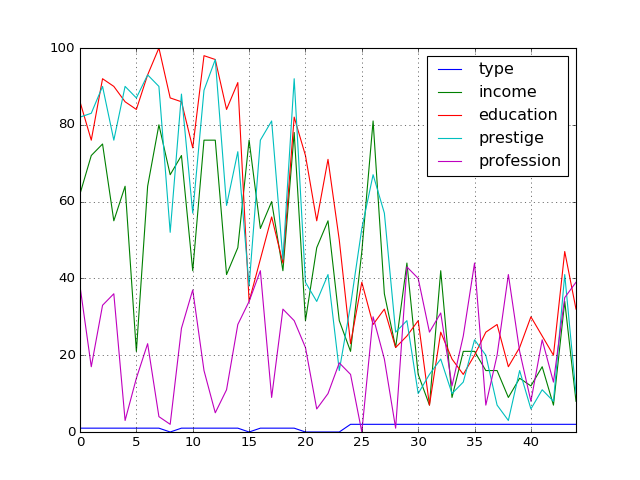

In [8]:
# check box
checkboxes = []
cb_container = widgets.HBox()

def cb_observe_callback(data):
    def callback(change=None):
        fields = []
        for c in cb_container.children:
            if c.value:
                fields.append(c.description)
        ax.cla()
        if fields:
            data[fields].plot(ax=ax)

        plt.grid(True)
        plt.draw()
    return callback

# prepare checkbox
for k in data.keys():
    cb = widgets.Checkbox(description=k, value=True, width=90)
    #display(dir(cb))
    cb.observe(cb_observe_callback(df))
    checkboxes.append(cb)

cb_container.children=[i for i in checkboxes]


# graphic
ax = plt.figure().gca()

    
# button
#button = widgets.Button(description="Update the graph")

#display(button)
plt.show()
display(widgets.HTML('<h3>SELECT THE FIELDS</h3>'))
display(cb_container)
cb_observe_callback(df)()